### We try to use a gaussian distribution up to 6 beam sigma_x of SSC. 
- We consider round beam
- Twiss parameters are included in the rotation
- Motion restricted in the H plane. This means that y,py =0. x, px are given initial values. px0 is set to 0 for simplicity. 
- The elements, the machine and the functions are imported from utils.
- In this case the initial distribution is imported from the folder ./my_distributions

In [1]:
import os
import sys
import numpy as np
from math import *
import pandas as pd
import random
import matplotlib.pyplot as plt
from dotted_dict import DottedDict
import PyNAFF as pnf
sys.path.append('./utils')
from my_elements import *
from my_machines import *
from my_functions import *

### Plotting parameters

In [2]:
params = {'legend.fontsize': 12,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 18,
          'axes.titlesize': 18,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Define the machine parameters
- The parameters here correspond to HL-LHC. Obtained from MAD-X. They should be crosschecked. 

In [3]:
f_rev = 11.2455e3  # revolution frequency [Hz]
# Relativistic parameters
gamma_rel = 7460.52252807237 # from madx twiss
beta_rel = sqrt(1-(1/gamma_rel)**2)
# Twiss parameters
twiss = DottedDict()
twiss.beta_x = 115.75 #at IP3 #obtained from madx twiss. should be crossed check
twiss.beta_y = 1. 
twiss.alpha_x = 0 
twiss.alpha_y = 0 
twiss.gamma_x = (1+twiss.alpha_x**2)/twiss.beta_x
twiss.gamma_y = (1+twiss.alpha_y**2)/twiss.beta_y

In [4]:
Qx_init = 2*pi*62.775
Qy_init = 2*pi*62.32 

### Define the study parameters

In [5]:
turns = 1000
particles = 15000
ex_norm = 2.5e-6 # [m]
max_aperture_value = 3e-2 # ~ radius of LHC vaccume chamber

### Calculate beam sigma

\begin{equation}
\sigma = \sqrt{e_{geom}\beta(s)} \\
e_{geom} = \frac{e_{norm}}{\beta_{rel}\gamma_{rel}}
\end{equation}


In [6]:
ex_geom = ex_norm/(beta_rel*gamma_rel)
sigma_x = sqrt(twiss.beta_x*ex_geom)
sigma_px = sqrt(ex_geom/twiss.beta_x)
print(sigma_x, sigma_px)

0.00019694541882215593 1.7014723008393603e-06


### Define the configuration of the machine

In [7]:
flag_oct = False
flag_noise = True
flag_BB = False
flag_feedback = True
flag_detuner = True
k3 = 5825.61 #1.
if flag_detuner:
    k3_equivalent = k3 # this is not correct in general to be fixed
segments = 8
Delta = 1.0*sigma_px # normalised in beam sigma , xaviers
ksi = 0.01 # the normalisation in beam sigma , is done in the respective function in ./utiles/my_elements.py
gain = 0.2*sigma_px
elements_list = [flag_oct, flag_noise, flag_BB, flag_feedback, flag_detuner]
elements_list_str = ['oct', 'noise', 'BB', 'feedback', 'detuner']
study_name = ''
for index,element in enumerate(elements_list):
    if element == True:
        study_name = study_name + elements_list_str[index]+ '_'
print(study_name)

noise_feedback_detuner_


### Import the initial distribution
- Plot beam profiles
- Plot phase space

In [8]:
df_0  = pd.read_pickle('./my_distributions/ex_norm{}_betax{}_particles{}.pkl'.format(ex_norm, twiss.beta_x, particles)) # df_0 the data frame with the initial distribution

In [9]:
bunch = create_bunch(particles)
x_initial, px_initial = df_0['x'][0], df_0['px'][0]
bunch.x, bunch.px, bunch.y, bunch.py = df_0['x'][0], df_0['px'][0], df_0['y'][0], df_0['py'][0] # type(df_0['x']) : series, type(df_0['x'][0]): nd.array

Text(0.5, 1.0, 'Angle')

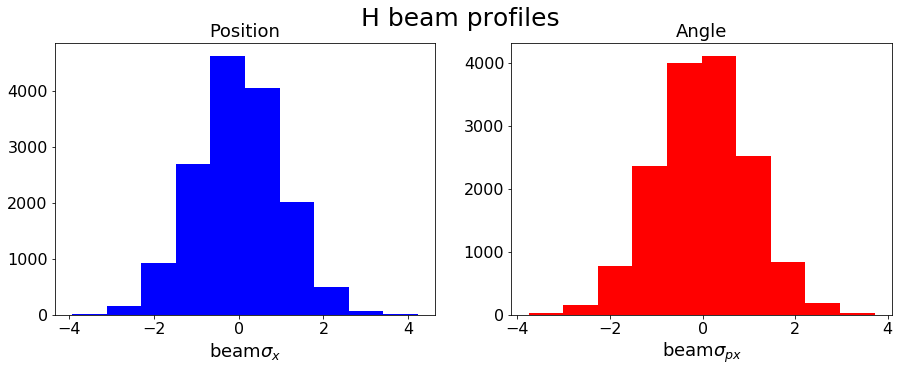

In [10]:
f = plt.figure(figsize=(15,5))
f.suptitle('H beam profiles', fontsize = 25)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.hist(x_initial/sigma_x, color = 'b')
ax.set_xlabel('beam'+r'$\sigma_{x}$')
ax.set_title('Position')
ax2.hist(px_initial/sigma_px, color = 'r')
ax2.set_xlabel('beam'+r'$\sigma_{px}$')
ax2.set_title('Angle')
#plt.savefig('./figures/H_beam_profile.png')

In [11]:
# Compute emittance, Sanity check
e_x = cmp_emit(bunch.x, bunch.px)
print('normalised emittance',e_x*beta_rel*gamma_rel)
print('geometric emittance',e_x)

normalised emittance 2.507882830720772e-06
geometric emittance 3.361537806250132e-10


Text(0, 0.5, '$px \\cdot $1e-3')

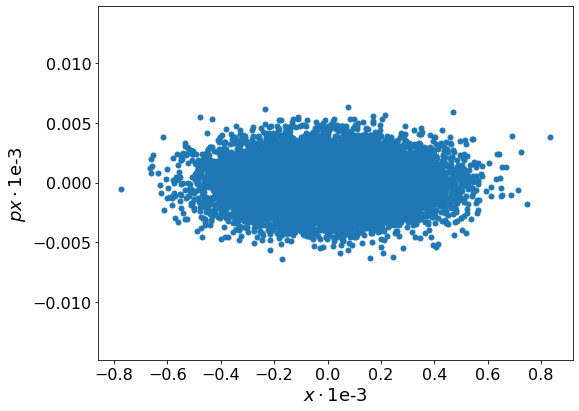

In [12]:
plt.scatter(bunch.x*1e3, bunch.px*1e3)
#plt.scatter(bunch.x/sqrt(twiss.beta_x*ex_geom)*1e3, bunch.px*sqrt(twiss.beta_x/ex_geom)*1e3) #normalised coordiantes
plt.xlabel(r'$x \cdot $1e-3')
plt.ylabel(r'$px \cdot $1e-3')

### Initialise data frame to save the turn by turn data

In [13]:
df = pd.DataFrame({'turn':[], 'x':[], 'px':[], 'y':[], 'py':[]})
# Append the initial values, not normalised
df = df.append({'turn':0, 'x':bunch.x, 'px':bunch.px, 'y':bunch.y, 'py':bunch.py}, ignore_index = True)

### Plot the evolution of phase space for the first ten turns

flag_detuner True, flag_noise True, flag_BB False, flag_feedback True
aperture limit is 0.03 [m]
k3 equivalent 5825.61
Delta 1.7014723008393603e-06
g 3.402944601678721e-07


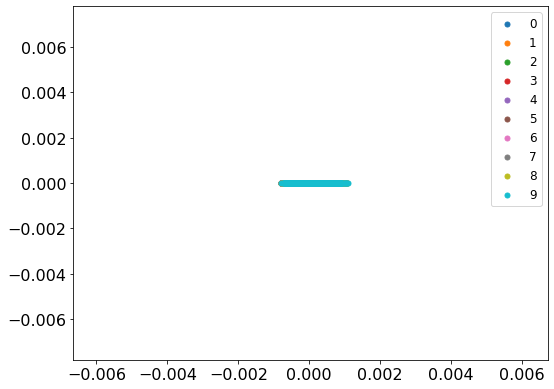

In [14]:
for turn in range(0, 10): #plot for the first 10 turns
    plt.scatter(bunch.x, bunch.px, label= turn)
    if flag_detuner:
        bunch = my_machine_with_detuners(Qx_init, Qy_init, k3_equivalent, turn, bunch, twiss, flag_detuner, flag_noise,flag_BB, flag_feedback, max_aperture_value, Delta, ksi, gain, sigma_x, sigma_px)
    else:
        bunch = my_machine(Qx_init, Qy_init, segments, k3, turn, bunch, twiss, flag_oct, flag_noise,flag_BB, flag_feedback, max_aperture_value, Delta, ksi, gain, sigma_x, sigma_px)
    plt.legend()
#plt.xlim(-2.5e-3,2.5e-3)

    

flag_detuner True, flag_noise True, flag_BB False, flag_feedback True
aperture limit is 0.03 [m]
k3 equivalent 5825.61
Delta 1.7014723008393603e-06
g 3.402944601678721e-07


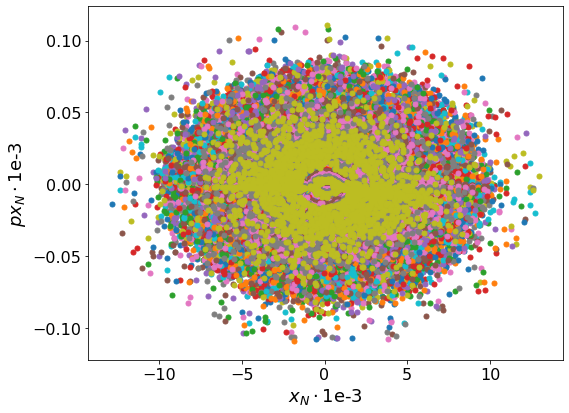

In [15]:
# Re-initialise the bunch as the initial coordinates were used in the iteration above
bunch.x = x_initial 
bunch.px = px_initial
for turn in range(1, turns): #we start form 1 as we have already include the intiial conditions
    plt.scatter(bunch.x*1e3, bunch.px*1e3)#,label= turn)
    if flag_detuner:
        bunch = my_machine_with_detuners(Qx_init, Qy_init, k3_equivalent, turn, bunch, twiss, flag_detuner, flag_noise,flag_BB, flag_feedback, max_aperture_value, Delta, ksi, gain, sigma_x, sigma_px)
    else:
        bunch = my_machine(Qx_init, Qy_init, segments, k3, turn, bunch, twiss, flag_oct, flag_noise,flag_BB, flag_feedback, max_aperture_value, Delta, ksi, gain, sigma_x, sigma_px)
    df = df.append({'turn':turn, 'x':bunch.x, 'px':bunch.px, 'y':bunch.y, 'py':bunch.py}, ignore_index = True)
    #plt.legend()
plt.xlabel(r'$x_N \cdot $1e-3')
plt.ylabel(r'$px_N \cdot $1e-3')  
df.to_pickle('./turn_by_turn_data/{}betax{}_H_particles{}_turns{}.pkl'.format(study_name, twiss.beta_x,particles,turns))

### Calculate tune shift with amplitude (Jx)
- We need to store the data in groups of particles. 
- In our data frames are in groups of turns
- Calculate Jx

In [16]:
x_data = {}
px_data = {}
y_data = {}
py_data = {}
for particle in range(particles):
    x_data[particle] = []
    px_data[particle] = []
    y_data[particle] = []
    py_data[particle] = []

In [ ]:
for particle in range(particles):
    for turn in range(turns):
        x_data[particle].append(df.at[turn,'x'][particle])
        px_data[particle].append(df.at[turn,'px'][particle])
        y_data[particle].append(df.at[turn,'y'][particle])
        py_data[particle].append(df.at[turn,'py'][particle])

In [ ]:
lost_particles = []
Qx_list = []
Qy_list = []

for particle in range(particles):
    if np.isnan(x_data[particle]).any() or np.isnan(px_data[particle]).any():
        lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x = x_data[particle] # normalise by derivation with beta function
        signal_y = y_data[particle] # normalise by derivation with beta function
        #plt.plot(signal_x[:10])
        Qx_list.append(pnf.naff(signal_x, turns, 1, 0, False)[0][1])
        #Qy_list.append(pnf.naff(signal_y, turns, 1, 0, False)[0][1])

### Use normalised coordiantes
\begin{equation}
x_{N} = \frac{x}{\sqrt{\beta(s)}} \\
px_{N} = px \cdot \sqrt{\beta(s)}
\end{equation}

### Calculate initial actions Jx
\begin{equation}
J_x = \frac{x_{N}^2 + px_{N}^2}{2} 
\end{equation}

In [ ]:
x_norm = df.at[0,'x']/sqrt(twiss.beta_x) # the index 0 corresponds to turn
px_norm = df.at[0,'px']*sqrt(twiss.beta_x)
Jx_initial = (x_norm**2 + px_norm**2)

In [ ]:
Qx_list_plot = [1-i for i in Qx_list]
plt.scatter(Jx_initial*1e9, Qx_list_plot) # the index 0 corresponds to turn
plt.xlabel('2Jx'+r'$\cdot 10^{-9}$')
plt.ylabel('Qx')
plt.tight_layout()
#plt.ylim(0.8498,0.85025)
#plt.savefig('./figures/tune_shift_test.png')

### Emittance growth

In [17]:
e_x = [] # list for the values of geometric emittance over turns
for turn in range(turns):
    e_x.append(cmp_emit(df.at[turn,'x']/sqrt(twiss.beta_x), df.at[turn,'px']*sqrt(twiss.beta_x) ))

Text(0, 0.5, '$\\frac{\\epsilon_{geom}}{\\epsilon_{geom_0}} $')

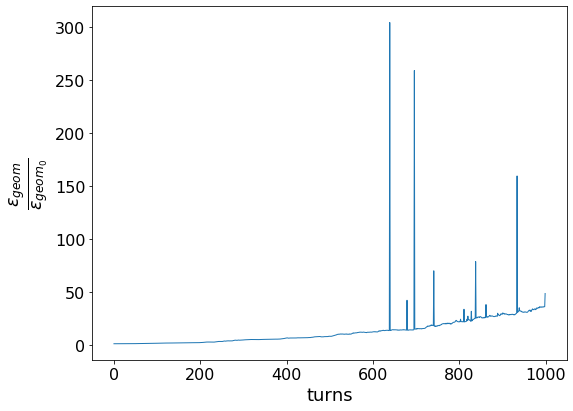

In [19]:
plt.plot(e_x/e_x[0])
plt.xlabel('turns')
plt.xlabel('turns')
plt.ylabel(r'$\frac{\epsilon_{geom}}{\epsilon_{geom_0}} $', fontsize = 25)
#plt.savefig('./figures/emittance_{}.png'.format(study_name))

#### Compare with theoretical rate
- According to Lebedev in the absence of feedback the emittance growth per turn is: 
\begin{equation}
\frac{d\epsilon}{dn} = \frac{\Delta^2}{2}
\end{equation}

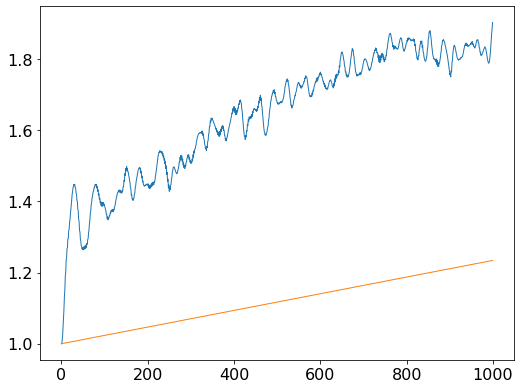

In [21]:
turns_list = np.arange(0,turns)
A = 3.
theory_rate = A*((ksi**2)*((Delta**2))/(2*gain**2))
plt.plot(e_x/e_x[0])
plt.plot(turns_list, 1 + theory_rate*turns_list)

### Linear fit of the emittance evolution

In [20]:
turns_list = np.arange(0,1000)
[m_h,b_h], cov_h = np.polyfit(turns_list, e_x, 1, cov= True)

1.4475039952617936e-16


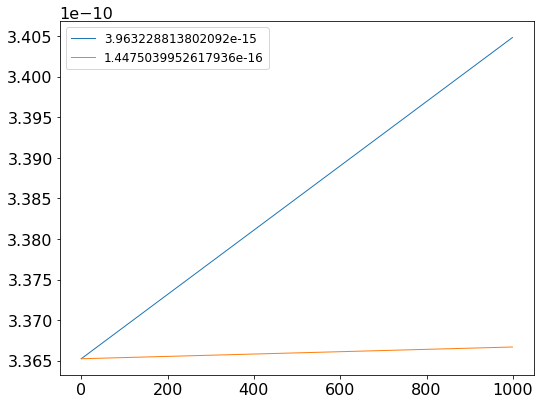

In [25]:
plt.plot(turns_list, m_h*turns_list+e_x[0], label = m_h)
plt.plot(turns_list, theory_rate*turns_list+ e_x[0], label = theory_rate)
print(Delta**2/2.)
plt.legend()

In [ ]:
e_x[100]*beta_rel*gamma_rel